<a href="https://colab.research.google.com/github/semishen/ML100Days/blob/master/Day_030_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 作業 : (Kaggle)鐵達尼生存預測
https://www.kaggle.com/c/titanic

# [作業目標]
- 試著調整特徵篩選的門檻值, 觀察會有什麼影響效果

# [作業重點]
- 調整相關係數過濾法的篩選門檻, 看看篩選結果的影響 (In[5]~In[8], Out[5]~Out[8])
- 調整L1 嵌入法篩選門檻, 看看篩選結果的影響 (In[9]~In[11], Out[9]~Out[11])

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId'] , axis=1)
print(df.shape)
df.head()

(891, 11)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


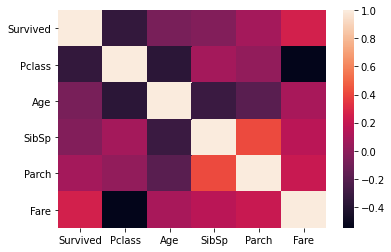

In [2]:
# 計算df整體相關係數, 並繪製成熱圖
import seaborn as sns
import matplotlib.pyplot as plt
corr = df.corr()
sns.heatmap(corr)
plt.show()

In [12]:
# 記得刪除 Survived
# df = df.drop(['Survived'] , axis=1)

#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = df.columns[(df.dtypes == 'float64') | (df.dtypes == 'int64')].values
num_features
# for dtype, feature in zip(df.dtypes, df.columns):
#     if dtype == 'float64' or dtype == 'int64':
#         num_features.append(feature)
# print(f'{len(num_features)} Numeric Features : {num_features}\n')

# 削減文字型欄位, 只剩數值型欄位
num_df = df.loc[:,num_features]
num_df = num_df.fillna(-1)
MMEncoder = MinMaxScaler()
num_df.head()

,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


# 作業1
### Q1: 鐵達尼生存率預測中，試著變更兩種以上的相關係數門檻值，觀察預測能力是否提升?
### A1: 相關係數區間從 -0.1 ~ 0.1 調到 -0.05 ~ 0.05，特徵從 'Pclass', 'Fare' 增加成 'Pclass', 'Age', 'Parch', 'Fare'，分數提升了 0.025 左右。

In [13]:
# 原始特徵 + 邏輯斯迴歸
train_X = MMEncoder.fit_transform(num_df)
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.70041428661101

In [27]:
# 篩選相關係數1 -0.1 <= corr <=0.1
high_list = list(corr[(corr['Survived']>0.1) | (corr['Survived']<-0.1)].index)
high_list.pop(0)
print(high_list)

['Pclass', 'Fare']


In [28]:
# 特徵1 + 邏輯斯迴歸
train_X = MMEncoder.fit_transform(num_df[high_list])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.6790973573535873

In [29]:
# 篩選相關係數2 -0.05 <= corr <=0.05
high_list = list(corr[(corr['Survived']>0.05) | (corr['Survived']<-0.05)].index)
high_list.pop(0)
print(high_list)

['Pclass', 'Age', 'Parch', 'Fare']


In [30]:
# 特徵2 + 邏輯斯迴歸
train_X = MMEncoder.fit_transform(num_df[high_list])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.703785073127864

# 作業2
### Q2: 續上題，使用 L1 Embedding 做特徵選擇(自訂門檻)，觀察預測能力是否提升?
### A2: 若 alpha = 0.005，篩選出了 'Pclass', 'Age', 'Parch' 三個特徵，模型預測能力降了一些。

In [43]:
from sklearn.linear_model import Lasso
L1_Reg = Lasso(alpha=0.005)
train_X = MMEncoder.fit_transform(num_df)
L1_Reg.fit(train_X, train_Y)
L1_Reg.coef_

array([-0.39126312, -0.1355752 , -0.        ,  0.03068895,  0.        ])

In [44]:
from itertools import compress
L1_mask = list((L1_Reg.coef_>0) | (L1_Reg.coef_<0))
L1_list = list(compress(list(num_df), list(L1_mask)))
L1_list

['Pclass', 'Age', 'Parch']

In [45]:
# L1_Embedding 特徵 + 線性迴歸
train_X = MMEncoder.fit_transform(num_df[L1_list])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.6992906911053921